# 0. Import libraries and data

In [3]:
import pandas as pd
import numpy as np
import pycaret
import seaborn as sns
import matplotlib.pyplot as plt
import re
import requests
from bs4 import BeautifulSoup

%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


In [4]:
ufc_df = pd.read_csv("../data/ufc_combined.csv", index_col=0)

In [5]:
ufc_df.head()

,fighter1,fighter2,winner,weight_class,title_fight,method,end_round,fight_year,win_fighter1,lose_fighter1,draw_fighter1,nc_fighter1,height_fighter1,reach_fighter1,stance_fighter1,SLpM_fighter1,Str_Acc_fighter1,SApM_fighter1,Str_Def_fighter1,TD_Avg_fighter1,TD_Acc_fighter1,TD_Def_fighter1,Sub_Avg_fighter1,win%_fighter1,born_year_fighter1,win_fighter2,lose_fighter2,draw_fighter2,nc_fighter2,height_fighter2,reach_fighter2,stance_fighter2,SLpM_fighter2,Str_Acc_fighter2,SApM_fighter2,Str_Def_fighter2,TD_Avg_fighter2,TD_Acc_fighter2,TD_Def_fighter2,Sub_Avg_fighter2,win%_fighter2,born_year_fighter2
0,Santiago Ponzinibbio,Neil Magny,1,Welterweight,f,KO/TKO,4,2018,28,3,0,0,"6' 0""","73""",Orthodox,4.27,39.0,4.02,64.0,0.54,44.0,60.0,0.0,90.322580,1986,21,8,0,0,"6' 3""","80""",Orthodox,3.86,46.0,2.22,56.0,2.62,46.0,60.0,0.3,72.413795,1987
1,Ricardo Lamas,Darren Elkins,1,Featherweight,f,KO/TKO,3,2018,19,7,0,0,"5' 8""","71""",Orthodox,2.87,45.0,2.61,59.0,1.66,32.0,47.0,1.0,73.076920,1982,25,7,0,0,"5' 10""","71""",Orthodox,3.36,37.0,2.83,53.0,2.68,35.0,57.0,1.3,78.125000,1984
2,Johnny Walker,Khalil Rountree Jr.,1,Light Heavyweight,f,KO/TKO,1,2018,15,3,0,0,"6' 5""","82""",Orthodox,5.37,70.0,3.36,25.0,0.89,100.0,100.0,2.6,83.333336,1992,8,2,0,2,"6' 1""","76""",Southpaw,2.30,34.0,3.29,38.0,0.00,0.0,50.0,0.3,66.666664,1990
3,Cezar Ferreira,Ian Heinisch,0,Middleweight,f,DEC,3,2018,14,7,0,0,"6' 1""","78""",Southpaw,1.83,42.0,2.14,55.0,2.97,59.0,90.0,0.5,66.666664,1985,12,1,0,0,"5' 11""",NaN,Orthodox,3.49,58.0,1.67,52.0,0.81,14.0,50.0,1.6,92.307690,1988
4,Marlon Vera,Guido Cannetti,1,Bantamweight,f,SUB,2,2018,12,5,1,0,"5' 8""","70""",Switch,3.23,44.0,3.93,52.0,0.78,37.0,68.0,1.3,66.666664,1992,8,5,0,0,"5' 6""","68""",Southpaw,2.80,52.0,1.95,51.0,2.80,50.0,75.0,0.3,61.538460,1979


___

# 1. Data Cleaning / EDA

Percentage of fights ending in a particular `method`
- majority of fights end in DEC (decision by 3 judges)
    - how judges score fights are based on 4 main aspects:
        - Effective striking
        - Effective grappling
        - Effective aggressiveness 
        - Control of fighting area

    
    
- secondmost fight-ending `method` is KO/TKO ==> this is mostly by strikes that render the opponent unconscious (KO) or unable to fight back (TKO)
- as shown by the above 2 points, the top 2 `methods` (DEC and KO/TKO) are highly dependent on the striking aspects of MMA.
- as such this is our motivation to analyse strikes using Computer Vision.

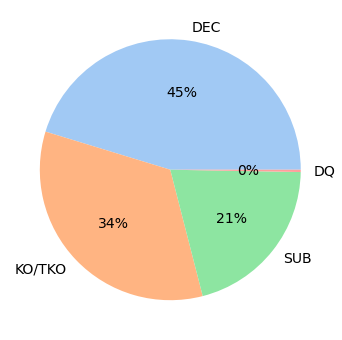

In [6]:
temp = ufc_df['method'].value_counts()
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(12,6))
plt.pie(temp, labels=temp.index, colors = colors, autopct='%.0f%%',textprops={'fontsize': 14});

In [7]:
# analyze methods won by weight class
weightclass = ufc_df.groupby(['weight_class','method']).count()
weightclass = weightclass.iloc[:,:1].reset_index()
weightclass.columns = ['weight_class', 'method', 'total_method']

# adding total fights column
sum_fights = weightclass.groupby('weight_class').sum().reset_index()
sum_fights.columns = ['weight_class','total_fights']
weightclass = pd.merge(weightclass,sum_fights, on='weight_class')

/Users/mohammadiyliahaziq/opt/anaconda3/envs/pycaret/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


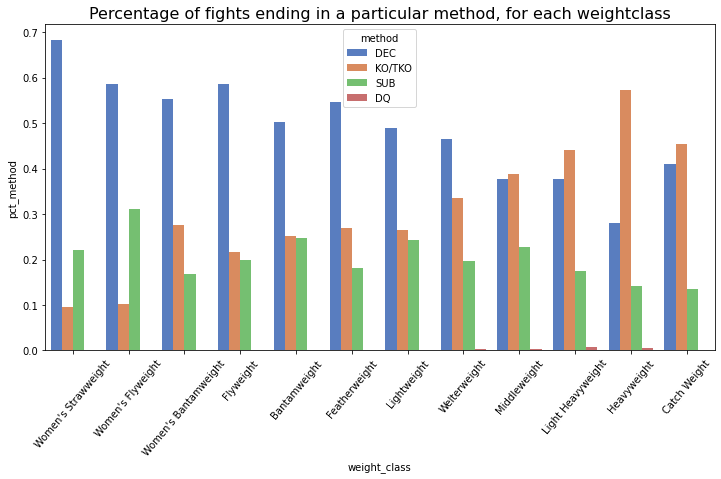

In [8]:
# drop weight_class with less than 20 fights
cols = weightclass[weightclass['total_fights']<20].index
weightclass = weightclass.drop(cols)

# create a list in ascending order of weight
weight_list = ["Women's Strawweight","Women's Flyweight","Women's Bantamweight",'Flyweight','Bantamweight', 'Featherweight', 'Lightweight', 'Welterweight', 'Middleweight',
               'Light Heavyweight', "Heavyweight",'Catch Weight']

# creating column for percentage of finish ending in a particular method
weightclass['pct_method'] = np.round(weightclass['total_method'] / weightclass['total_fights'], 3)

# plot barchart
plt.figure(figsize=(12,6))
sns.barplot(weightclass['weight_class'], weightclass['pct_method'], hue=weightclass['method'],palette='muted', order=weight_list)
plt.xticks(rotation = 50);
plt.title("Percentage of fights ending in a particular method, for each weightclass", fontsize=16);

Interestingly, we can see that as the weight class increases, 
- less fights finish by Decisions
- more fights finish by KO/TKO
- no direct pattern for Submissions

This is most likely justified by the fact that heavier fighters have higher knockout power

### Analyzing Strikes Landed per Minute (SLpM)

In [9]:
# function to analyse SLpM across different methods
def SLpM_by_method(method):
    
    temp1 = ufc_df[(ufc_df['method']== method) & (ufc_df['winner']==1)]
    temp1 = temp1[['SLpM_fighter1','SLpM_fighter2']]
    temp1.rename(columns={'SLpM_fighter1':'winner_SLpM', 'SLpM_fighter2':'loser_SLpM'}, inplace=True)

    temp2 = ufc_df[(ufc_df['method']==method) & (ufc_df['winner']==0)]
    temp2 = temp2[['SLpM_fighter1','SLpM_fighter2']]
    temp2.rename(columns={'SLpM_fighter2':'winner_SLpM', 'SLpM_fighter1':'loser_SLpM'}, inplace=True)
    temp2

    temp_total = pd.merge(temp1, temp2, how='outer')
    SLpM_diff = len(temp_total[temp_total['winner_SLpM']>temp_total['loser_SLpM']])/len(temp_total)*100
    print(f"Fighters that win a fight by {str(method)} have higher SLpM {SLpM_diff:.2f} % of the time")
    
    mean_diff = temp_total['winner_SLpM'].mean() - temp_total['loser_SLpM'].mean()
    print(f'On average, winners by {str(method)} has {mean_diff:.2f} more strikes per minute than losers')
    
    temp_total['pct_diff'] = (temp_total['winner_SLpM'] - temp_total['loser_SLpM']) / (temp_total['winner_SLpM'] + temp_total['loser_SLpM'])*100
    sns.boxplot(temp_total['pct_diff']);
    pct_diff = temp_total['pct_diff'].mean()
    print(f"On average, fighters that win by {str(method)} have {pct_diff:.2f} % higher SLpM than their opponents")
    plt.title(f'Strikes Landed per Minute for fighters that win by {method}')
    plt.show()

    
    return temp_total

### Analyse SLpM for winners in different methods

Fighters that win a fight by KO/TKO have higher SLpM 67.04 % of the time
On average, winners by KO/TKO has 0.63 more strikes per minute than losers
On average, fighters that win by KO/TKO have 11.76 % higher SLpM than their opponents


/Users/mohammadiyliahaziq/opt/anaconda3/envs/pycaret/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


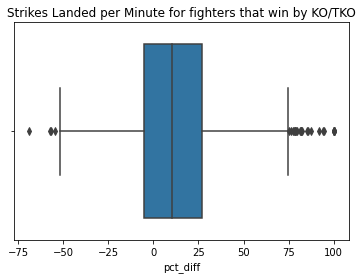



Fighters that win a fight by DEC have higher SLpM 61.43 % of the time
On average, winners by DEC has 0.38 more strikes per minute than losers
On average, fighters that win by DEC have 6.78 % higher SLpM than their opponents


/Users/mohammadiyliahaziq/opt/anaconda3/envs/pycaret/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


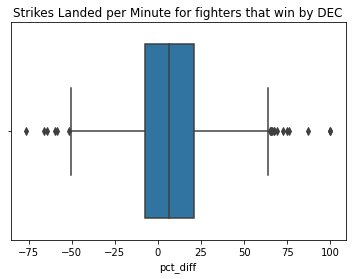



Fighters that win a fight by SUB have higher SLpM 54.86 % of the time
On average, winners by SUB has 0.13 more strikes per minute than losers


/Users/mohammadiyliahaziq/opt/anaconda3/envs/pycaret/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


On average, fighters that win by SUB have 4.38 % higher SLpM than their opponents


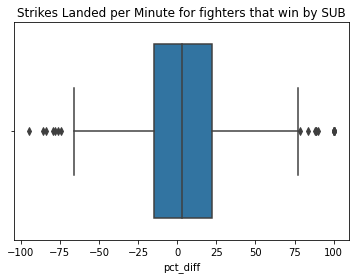

In [10]:
KO = SLpM_by_method('KO/TKO')
print('\n')
DEC = SLpM_by_method('DEC')
print('\n')
SUB = SLpM_by_method('SUB')

### SLpM for all types of methods

61.81251391672233
7.915984459563337


/Users/mohammadiyliahaziq/opt/anaconda3/envs/pycaret/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


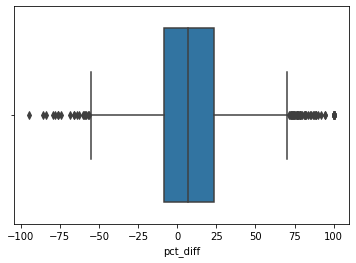

In [11]:
temp1 = ufc_df[ufc_df['winner']==1]
temp1 = temp1[['SLpM_fighter1','SLpM_fighter2']]
temp1.rename(columns={'SLpM_fighter1':'winner_SLpM', 'SLpM_fighter2':'loser_SLpM'}, inplace=True)

temp2 = ufc_df[ufc_df['winner']==0]
temp2 = temp2[['SLpM_fighter1','SLpM_fighter2']]
temp2.rename(columns={'SLpM_fighter2':'winner_SLpM', 'SLpM_fighter1':'loser_SLpM'}, inplace=True)
temp2

temp_total = pd.merge(temp1, temp2, how='outer')

print(len(temp_total[temp_total['winner_SLpM']>temp_total['loser_SLpM']])/len(temp_total)*100)

temp_total['pct_diff'] = (temp_total['winner_SLpM'] - temp_total['loser_SLpM']) / (temp_total['winner_SLpM'] + temp_total['loser_SLpM'])*100
sns.boxplot(temp_total['pct_diff']);
print(temp_total['pct_diff'].mean())

In general, winners of any fight have 8% more SLpM than their opponents

### Analyzing how much SLpM differ between winner and fighters for each method

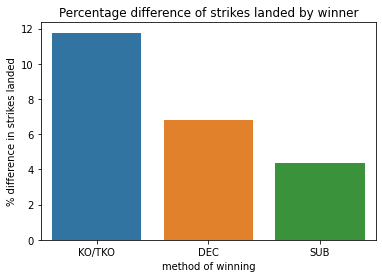

In [12]:
i = 2
SLpM_compare = [KO.mean()[i], DEC.mean()[i], SUB.mean()[i]]
SLpM_compare

sns.barplot(x=["KO/TKO", "DEC", "SUB"] , y=np.array(SLpM_compare))
plt.title(f'Percentage difference of strikes landed by winner')
plt.ylabel("% difference in strikes landed")
plt.xlabel('method of winning');

It is not surprising that fighters that win by KO/TKO and DEC have higher SLpM than their opponents. What is intersting though is that even for submissions, it seems that SLpM is distinctively higher for winner, which underlines the importance of striking abilities in a fight.

### Analysing relationship between striking-related stats and method

/Users/mohammadiyliahaziq/opt/anaconda3/envs/pycaret/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,SLpM_fighter
method,
DEC,3.03
DQ,2.90
KO/TKO,3.03
SUB,2.74


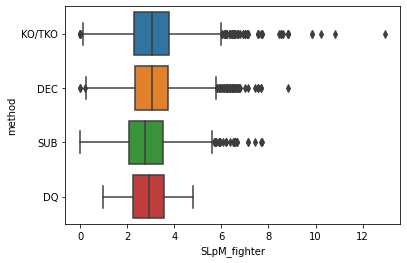

In [13]:
temp1 = ufc_df[['method','SLpM_fighter1']]
temp2 = ufc_df[['method','SLpM_fighter2']]
temp1.columns = ['method','SLpM_fighter']
temp2.columns = ['method','SLpM_fighter']

comb_temp = pd.concat((temp1,temp2),axis=0)

sns.boxplot(comb_temp['SLpM_fighter'],comb_temp['method']);
comb_temp.groupby(by='method').median()

/Users/mohammadiyliahaziq/opt/anaconda3/envs/pycaret/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,Str_Acc_fighter
method,
DEC,42.0
DQ,47.0
KO/TKO,44.0
SUB,43.0


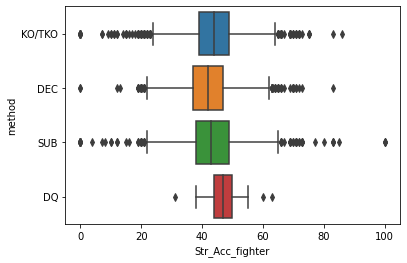

In [14]:
temp1 = ufc_df[['method','Str_Acc_fighter1']]
temp2 = ufc_df[['method','Str_Acc_fighter2']]
temp1.columns = ['method','Str_Acc_fighter']
temp2.columns = ['method','Str_Acc_fighter']

comb_temp = pd.concat((temp1,temp2),axis=0)

sns.boxplot(comb_temp['Str_Acc_fighter'],comb_temp['method']);
comb_temp.groupby(by='method').median()

- In general, fighters that finish fights by KO/TKO or DEC seem to use more of their striking abilities as proven by the higher median values for SLpM (Strikes Landed per Minute) and Str_Acc (Strike Accuracy) in the tables above.
- This is also shown by the higher median and IQ range in the boxplots.

**explore relationship between reach_diff and win**

In [15]:
# data cleaning to convert string to float, so as to compute later on
ufc_df['reach_fighter1'] = ufc_df['reach_fighter1'].str.extract(r'(\d+)')
ufc_df['reach_fighter2'] = ufc_df['reach_fighter2'].str.extract(r'(\d+)')

ufc_df = ufc_df.astype({
    'reach_fighter1':float,
    'reach_fighter2':float
})

# convert from imperial to metric units
ufc_df['reach_fighter1'] = ufc_df['reach_fighter1'] * 2.54
ufc_df['reach_fighter2'] = ufc_df['reach_fighter2'] * 2.54
ufc_df['reach_diff'] = ufc_df['reach_fighter1'] - ufc_df['reach_fighter2']


/Users/mohammadiyliahaziq/opt/anaconda3/envs/pycaret/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


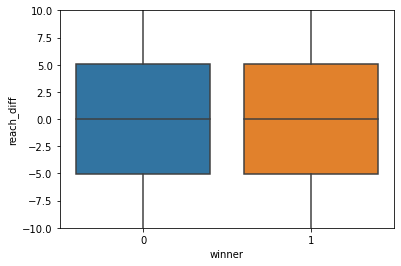

In [16]:
sns.boxplot(ufc_df['winner'],ufc_df['reach_diff'])
plt.ylim([-10,10]);

___

# 2. Feature Engineering and Data Cleaning

- by default, pycaret imputes null values 
    - numeric ==> mean
    - categorical ==> unknown constant
- as such, we only impute `reach_fighter1` and `reach_fighter2` with its median value based on respective weight class, using the below function. 

In [17]:
# impute null values for reach using median of each weightclass
weight_list = ["Women's Strawweight","Women's Flyweight","Women's Bantamweight",'Flyweight','Bantamweight', 'Featherweight', 'Lightweight', 'Welterweight', 'Middleweight',
               'Light Heavyweight', "Heavyweight",'Catch Weight']

null_list = ['reach_fighter1', 'reach_fighter2']

for i in weight_list:
    for j in null_list:
        median = ufc_df[ufc_df['weight_class']==i].median()[j]
        idx_list = ufc_df[(ufc_df['weight_class']==i) & (ufc_df[j].isnull())][j].index
        for idx in idx_list:
            ufc_df.loc[idx,j] = median

- feature engineer new column age from birth year and fight_year

In [18]:
# create new column: age
for i in range(len(ufc_df)):
    if ufc_df.loc[i,'born_year_fighter1'] == 'unk':
        ufc_df.loc[i,'born_year_fighter1']= ufc_df.loc[i,'fight_year']
    if ufc_df.loc[i,'born_year_fighter2'] == 'unk':
        ufc_df.loc[i,'born_year_fighter2']= ufc_df.loc[i,'fight_year']
        
ufc_df = ufc_df.astype({
    'fight_year':int,
    'born_year_fighter1':int,
    'born_year_fighter2':int,
})

ufc_df['age_fighter1'] = ufc_df['fight_year'] - ufc_df['born_year_fighter1'] 
ufc_df['age_fighter2'] = ufc_df['fight_year'] - ufc_df['born_year_fighter2'] 

- convert numerical features `height` from imperial to metric units
- convert features into apporpriate data types

In [19]:
# drop 3 null value rows to allow for the following computation 
ufc_df.dropna(axis=0, how='any', inplace=True, subset=['height_fighter1','height_fighter2'])
# converting height into numerical variable
ufc_df['height_fighter1'].replace(r'[\s]+', '', regex=True, inplace=True)
ufc_df['height_fighter1'].replace(r'[\"]+', '', regex=True, inplace=True)
ufc_df['height_fighter1'] = ufc_df['height_fighter1'].str.split(r"[\']")
ufc_df['height_fighter1'] = ufc_df['height_fighter1'].map(lambda x: (float(x[0])*30.48 + (float(x[1])*2.54)))

ufc_df['height_fighter2'].replace(r'[\s]+', '', regex=True, inplace=True)
ufc_df['height_fighter2'].replace(r'[\"]+', '', regex=True, inplace=True)
ufc_df['height_fighter2'] = ufc_df['height_fighter2'].str.split(r"[\']")
ufc_df['height_fighter2'] = ufc_df['height_fighter2'].map(lambda x: (float(x[0])*30.48 + (float(x[1])*2.54)))

ufc_df = ufc_df.astype({
    'reach_fighter1':float,
    'reach_fighter2':float,
    'fight_year':object,
    'born_year_fighter1':object,
    'born_year_fighter2':object,
})


- further drop redundant features
    - drop features that are not known before a fight, since this is a prediction model before a fight
    - W-L-D record for each figher is not updated for every fight, as such the data is misleading

In [20]:
# drop columns that are not known before a fight
ufc_df.drop(columns=['fighter1','fighter2','method', 'end_round'], inplace=True)

# drop columns that are not useful
ufc_df.drop(columns=['win_fighter1','win_fighter2','lose_fighter1','lose_fighter2',
                     'draw_fighter1','draw_fighter2','nc_fighter1', 'nc_fighter2','fight_year',
                     'born_year_fighter1','born_year_fighter2'], inplace=True)

In [21]:
ufc_df.to_csv('../data/ufc_df.csv', index=False)

___